In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re


from sklearn.model_selection import train_test_split

# K Means Clustering
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# DT 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV 

# Boosted DT 
from sklearn.ensemble import AdaBoostRegressor

# Scaler for ANN
from sklearn.preprocessing import StandardScaler

# ANN
from sklearn.neural_network import MLPRegressor

# KMeans 
from sklearn.cluster import KMeans

import scipy

In [2]:
os.listdir()


['Movie_Rankings.csv',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Ranked.csv',
 'Movies_Updated.ipynb',
 '.ipynb_checkpoints',
 'Movies - Personal Inquiry.ipynb',
 'Movies.csv',
 'MLR_Movies.ipynb']

In [3]:
data = pd.read_excel('Movies_2020.xlsx', 
                    dtype = {'ReleaseYear': int}
                    )

In [4]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama


In [5]:
print("There are ",data.shape[0], " movies in this dataset")

There are  157  movies in this dataset


In [6]:
data.dtypes

Name                   object
Rating                float64
WatchDate      datetime64[ns]
ReleaseYear             int64
Director               object
Genre                  object
dtype: object

In [7]:
data.isna().sum()

Name           0
Rating         0
WatchDate      0
ReleaseYear    0
Director       0
Genre          0
dtype: int64

#### The movie watchings are skewed heavily toward recent movies, with some noticable peaks in 1950s (due to Hitchcock & Audrey Hepburn films)

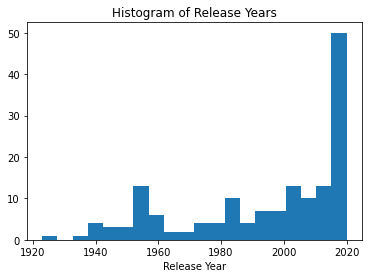

In [8]:
plt.hist(data['ReleaseYear'], bins = 20)
plt.xlabel('Release Year')
plt.title("Histogram of Release Years")
plt.show()

#### The Ratings also show that I generally rate movies highly, this distribution is right-skewed as well

In [9]:
data['Rating'].describe()

count    157.000000
mean       0.795987
std        0.132112
min        0.300000
25%        0.720000
50%        0.850000
75%        0.900000
max        0.990000
Name: Rating, dtype: float64

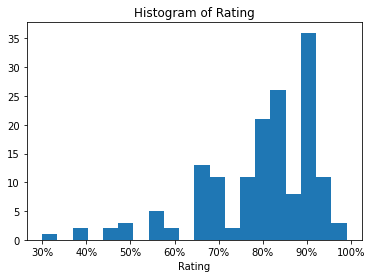

In [10]:
plt.hist(data['Rating'], bins = 20)
plt.xlabel('Rating')
plt.title("Histogram of Rating")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

#### My movie intake is quite high during the 2020 Global Covid-19 Pandemic. It also was pretty high in early 2016, as I was in my senior spring of college. This charts the quarterly sum of movies. 

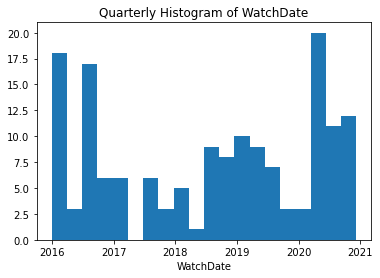

In [11]:
plt.hist(data['WatchDate'], bins = 20)
plt.xlabel('WatchDate')
plt.title("Quarterly Histogram of WatchDate")
plt.show()

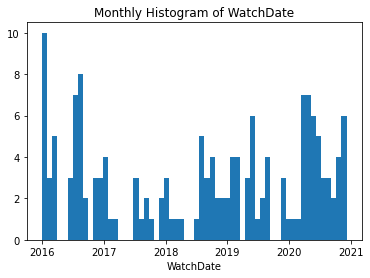

In [12]:
plt.hist(data['WatchDate'], bins = 60)
plt.xlabel('WatchDate')
plt.title("Monthly Histogram of WatchDate")
plt.show()

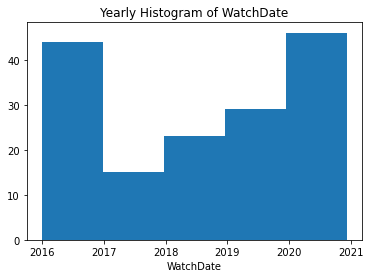

In [13]:
plt.hist(data['WatchDate'], bins = 5)
plt.xlabel('WatchDate')
plt.title("Yearly Histogram of WatchDate")
plt.show()

#### What is my average rating over time?

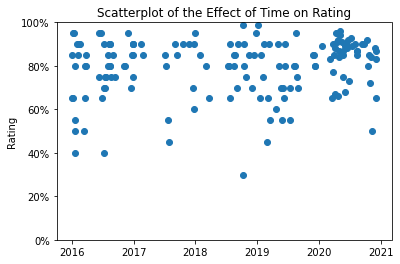

In [14]:
plt.scatter(data['WatchDate'], data['Rating'])
plt.title("Scatterplot of the Effect of Time on Rating")
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### Am I watching newer movies over time?

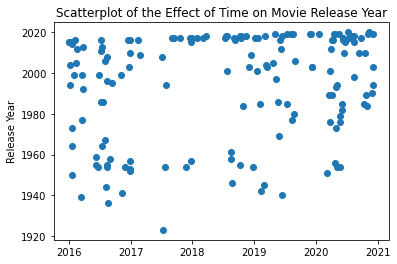

In [15]:
plt.scatter(data['WatchDate'], data['ReleaseYear'])
plt.title("Scatterplot of the Effect of Time on Movie Release Year")
plt.ylabel('Release Year')
plt.show()

#### Create a Monthly Aggregation to Summarize Trends

In [16]:

data['WatchMonth'] = data['WatchDate'].values.astype('datetime64[M]')

data_month = data.groupby(['WatchMonth']).agg(
                    count = pd.NamedAgg( column = 'Name', aggfunc = 'count'),
                    rating = pd.NamedAgg( column = 'Rating', aggfunc = 'mean'),
                    movieyear = pd.NamedAgg( column = 'ReleaseYear', aggfunc = 'mean')
                )
data_month = data_month.reset_index()
#data_month.rename(columns = {'Name':'Count'}, inplace = True)
data_month.head()


,WatchMonth,count,rating,movieyear
0,2016-01-01,10,0.720000,1994.30
1,2016-02-01,3,0.883333,2011.00
2,2016-03-01,5,0.720000,1984.00
3,2016-06-01,4,0.825000,1966.75
4,2016-07-01,6,0.700000,1996.00


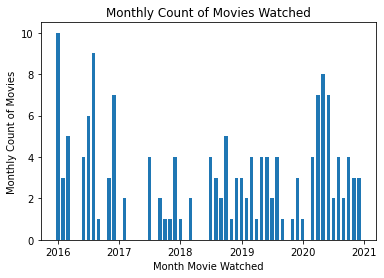

In [17]:
plt.bar(data_month['WatchMonth'], data_month['count'], width = 20)
plt.xlabel('Month Movie Watched')
plt.ylabel('Monthly Count of Movies')
plt.title('Monthly Count of Movies Watched')
plt.show()

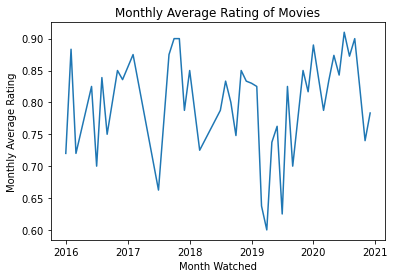

In [18]:
plt.plot(data_month['WatchMonth'], data_month['rating'])
plt.title('Monthly Average Rating of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Rating')
plt.show()

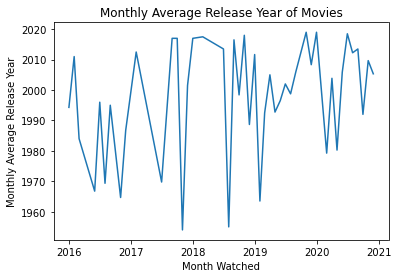

In [19]:
plt.plot(data_month['WatchMonth'], data_month['movieyear'])
plt.title('Monthly Average Release Year of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Release Year')
plt.show()

#### Is there a relationship between Year of the Movie Release and my Rating?

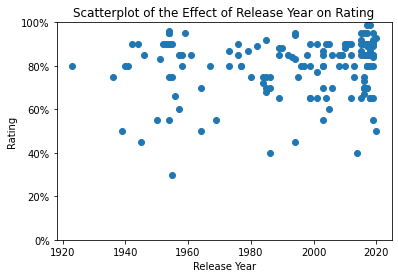

In [20]:
plt.scatter(data['ReleaseYear'], data['Rating'])
plt.title('Scatterplot of the Effect of Release Year on Rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### What are my highest rated movies?

In [21]:
data.sort_values(by=['Rating']).tail(5)

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth
120,Hidden figures,0.95,2020-04-10,2016,Theodore Melfi,Drama/History,2020-04-01
105,The Farewell,0.95,2019-08-17,2019,Lulu Wang,Drama/Comedy,2019-08-01
126,The rear window,0.96,2020-05-05,1954,Alfred Hitchcock,Noir/Mystery,2020-05-01
75,Colette,0.99,2018-10-12,2018,Wash Westmoreland,Historical/Drama,2018-10-01
83,On The Basis of Sex,0.99,2019-01-06,2017,Mimi Leder,Historical/Drama,2019-01-01


#### Which Director have I seen the most movies from?

In [22]:
data['Director'].value_counts().head()

Hitchcock           6
Robert Zemeckis     4
Michael Curtiz      4
Alfred Hitchcock    3
John Hughes         3
Name: Director, dtype: int64

### Label Encoding the Genre Column 

In [23]:
data[['Genre1','Genre2']] = data['Genre'].str.split('/',expand=True)

In [24]:
data['Genre2'] = data['Genre2'].fillna('Genre1')

In [25]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama


Due to the mispellings in the underlying dataset, do manual combinations to reduce the dimensionality of the dataset

In [26]:
#data['Genre1'].value_counts()

In [27]:
#data['Genre2'].value_counts()

In [28]:
#data['Genre_Romance'] = 0
#data.loc[ data['Genre'].str.contains('Romance'), 'Genre_Romance'] = 1


data['Romance_Ind'] = 0 
r = re.compile(r'.*(Romance).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Romance_Ind'] = 1
  
data['Comedy_Ind'] = 0 
r = re.compile(r'.*(Comedy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Comedy_Ind'] = 1
 
data['Drama_Ind'] = 0 
r = re.compile(r'.*(Drama).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Drama_Ind'] = 1

data['Thriller_Ind'] = 0 
r = re.compile(r'.*(Thriller).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Thriller_Ind'] = 1
 
data['Fantasy_Ind'] = 0 
r = re.compile(r'.*(Fantasy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Fantasy_Ind'] = 1

data['Crime_Ind'] = 0 
r = re.compile(r'.*(Crime).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Crime_Ind'] = 1

data['Sport_Ind'] = 0 
r = re.compile(r'.*(Sport).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Sport_Ind'] = 1

data['Historical_Ind'] = 0 
r = re.compile(r'.*(Historical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Historical_Ind'] = 1


data['Mystery_Ind'] = 0 
r = re.compile(r'.*(Mystery).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Mystery_Ind'] = 1


data['Action_Ind'] = 0 
r = re.compile(r'.*(Action).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Action_Ind'] = 1


data['Musical_Ind'] = 0 
r = re.compile(r'.*(Musical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Musical_Ind'] = 1


data['SciFi_Ind'] = 0 
r = re.compile(r'.*(Sci).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'SciFi_Ind'] = 1

data['Other_Ind'] = 0
data.loc[ (data['Romance_Ind'] == 0) & (data['Comedy_Ind'] == 0) & (data['Drama_Ind'] == 0) & \
          (data['Thriller_Ind'] == 0) & (data['Fantasy_Ind'] == 0) & (data['Crime_Ind'] == 0) & \
         (data['Sport_Ind'] == 0) & (data['Historical_Ind'] == 0) & (data['Mystery_Ind'] == 0) & \
         (data['Action_Ind'] == 0) & (data['Musical_Ind'] == 0 ) & (data['SciFi_Ind'] == 0)
         , 'Other_Ind'] = 1



In [29]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


In [30]:
data.describe()

,Rating,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.795987,1994.070064,0.242038,0.318471,0.560510,0.082803,0.070064,0.057325,0.050955,0.044586,0.108280,0.044586,0.070064,0.070064,0.025478
std,0.132112,25.775439,0.429688,0.467374,0.497913,0.276465,0.256071,0.233206,0.220610,0.207053,0.311728,0.207053,0.256071,0.256071,0.158075
min,0.300000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.720000,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.850000,2003.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,2016.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
data.iloc[:, 8:].sum()

Genre2            ScienceFictionDramaComedyDramaDramaDramaMusica...
Romance_Ind                                                      38
Comedy_Ind                                                       50
Drama_Ind                                                        88
Thriller_Ind                                                     13
Fantasy_Ind                                                      11
Crime_Ind                                                         9
Sport_Ind                                                         8
Historical_Ind                                                    7
Mystery_Ind                                                      17
Action_Ind                                                        7
Musical_Ind                                                      11
SciFi_Ind                                                        11
Other_Ind                                                         4
dtype: object

In [32]:
data.columns

Index(['Name', 'Rating', 'WatchDate', 'ReleaseYear', 'Director', 'Genre',
       'WatchMonth', 'Genre1', 'Genre2', 'Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind'],
      dtype='object')

In [33]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars VII: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,Hunger Games 3b,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


#### Split the Data

In [34]:
X = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind']]
y = data.loc[:, 'Rating']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = .30, train_size = .70, random_state = 42)
    

In [35]:
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(109, 14)
(109,)
(48, 14)
(48,)


In [36]:
X_Train.head()

,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
140,2017,0,0,1,0,0,0,1,0,0,0,0,0,0
11,2005,0,0,1,0,0,0,0,0,1,0,0,0,0
79,2018,0,0,1,0,0,0,0,1,0,0,0,0,0
68,2018,0,0,0,0,0,0,0,0,0,1,0,1,0
149,1989,0,0,0,0,0,0,0,0,0,0,0,1,0


#### We can't do Clustering on a Binary Dataset. We will have to get something else - such as 'Sentiment Score' using NLP Methods. 
#### Get Sentiment using NLTK, then use that as an input to Clustering 

### Decision Tree on Binary Genre + Release Year Data 

Basic Decision Tree Model

In [37]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.5435844370860925
Mean Squared Error: 0.01294895833333333


Grid Search for Best Parameters

In [38]:
def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['mse', 'mae','friedman_mse']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(10, 20, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeRegressor(random_state=42),
                       param_grid=param_grid, 
                       #scoring='neg_mean_squared_error',
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [39]:
make_GridSearchCV_DT(X_Train, Y_Train)

-0.13967487289417457
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 10, 'splitter': 'random'}


In [40]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

In [41]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 10,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.2792096942717477
Mean Squared Error: 0.010731147990835216


#### Boosted Decision Tree

In [42]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.9800804563854544
Mean Squared Error: 0.016610674939677977


In [43]:
def make_GridSearchCV_Boosted_DT(X_Train, Y_Train):

    losses = ['linear', 'square', 'exponential']
    learning_rates = np.arange(0.5,1,step=0.10)
    num_est = np.arange(10,100,step=5)

    param_grid = {'loss': losses, 'learning_rate': learning_rates, 'n_estimators': num_est}

    classifier = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [44]:
make_GridSearchCV_Boosted_DT(X_Train, Y_Train)

-0.19941503315191425
{'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 10}


In [45]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.3163755268774451
Mean Squared Error: 0.011042928031027454


#### Artificial Neural Network

In [46]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -1.1675117058011937
Mean Squared Error: 0.018183014865332234


In [47]:
# This one is only for the Polling Data 
def make_GridSearchCV_ANN(X_Train, Y_Train):
    
    activations = ['identity', 'relu', 'tanh', 'logistic']
    solvers = ['adam']
    hidden_layers = list(np.arange(5, 100, 5))
    
    init_learning_rates = [0.01, 0.05]
    
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPRegressor(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [48]:
make_GridSearchCV_ANN(X_Train, Y_Train)

-0.1337294530811456
{'activation': 'logistic', 'hidden_layer_sizes': 45, 'learning_rate_init': 0.01, 'solver': 'adam'}


#### We need to find some better features. Let's explore NLP Sentiment of the Movie Genre

### 1) NLTK Vader Compound Score

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [49]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def show_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [50]:
print(data.loc[0,['Genre1']])

word = str(data.loc[0,['Genre1']])
show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 


In [51]:
for i in range(0, 5):
    print(data.loc[i,['Genre1']])

    word = str(data.loc[i,['Genre1']])
    show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Fantasy
Name: 1, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Romance
Name: 2, dtype: object
compound: 0.5574, 
neg: 0.0, 
neu: 0.581, 
pos: 0.419, 
Genre1    Comedy
Name: 3, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 
Genre1    Comedy
Name: 4, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 


In [52]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    return (ss['compound'])


In [53]:
get_vader_score('crime')

-0.5423

In [54]:
# Apply this function to my Genre Columns
data['Genre1_NLTK'] = data['Genre1'].apply(get_vader_score)
data['Genre2_NLTK'] = data['Genre2'].apply(get_vader_score)
data['Genre_NLTK'] = (data['Genre1_NLTK'] + data['Genre2_NLTK']) / 2

#### Much of the NLTK Vader Compound Scores are Zero - let us look for a wider range of scores with other Libraries

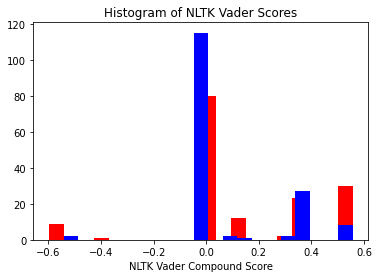

In [55]:
plt.hist(data['Genre1_NLTK'], bins = 20, color = 'red')
plt.hist(data['Genre2_NLTK'], bins = 20, color = 'blue')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

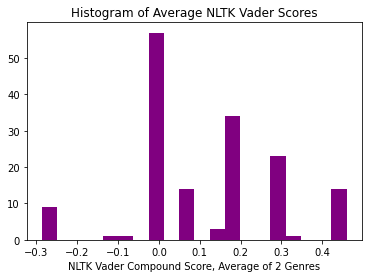

In [56]:
plt.hist(data['Genre_NLTK'], bins = 20, color = 'purple')
plt.xlabel('NLTK Vader Compound Score, Average of 2 Genres')
plt.title('Histogram of Average NLTK Vader Scores')
plt.show()

### 2) Textblob Polarity Score

In [57]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [121]:
data['Genre1_TB'] = data['Genre1'].apply(get_textBlob_score)
data['Genre2_TB'] = data['Genre2'].apply(get_textBlob_score)
data['Genre_TB'] = (data['Genre1_TB'] + data['Genre2_TB']) / 2

#### Textblob Scores are even less spread out than NLTK Vader Scores

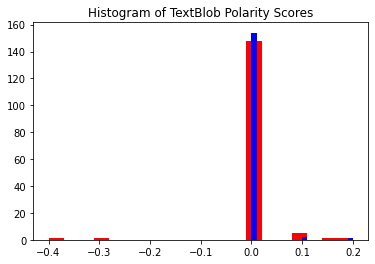

In [122]:
plt.hist(data['Genre1_TB'], bins = 20, color = 'red')
plt.hist(data['Genre2_TB'], bins = 20, color = 'blue')

plt.title('Histogram of TextBlob Polarity Scores')
plt.show()

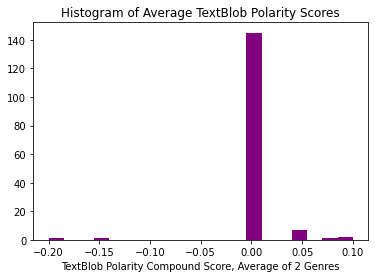

In [123]:
plt.hist(data['Genre_TB'], bins = 20, color = 'purple')
plt.xlabel('TextBlob Polarity Compound Score, Average of 2 Genres')
plt.title('Histogram of Average TextBlob Polarity Scores')
plt.show()

### 3) SpaCy Sentiment 

In [60]:
import spacy



In [61]:
#!python -m spacy download en

#spacy.load('en_core_web_sm')
nlp_spacy = spacy.load('en')

docs = nlp_spacy('romance comedy action crime drama horror musical')

for word in docs:
    print(word.text,word.pos_, word.sentiment)

romance NOUN 0.0
comedy PROPN 0.0
action NOUN 0.0
crime NOUN 0.0
drama NOUN 0.0
horror NOUN 0.0
musical ADJ 0.0


#### Examine NLTK vs Rating

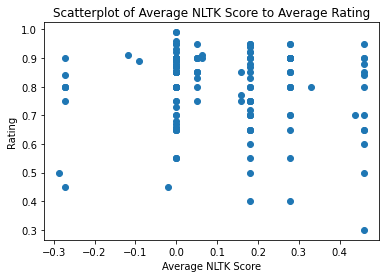

In [62]:
plt.scatter(data['Genre_NLTK'], data['Rating'])
plt.xlabel('Average NLTK Score')
plt.ylabel('Rating')
plt.title('Scatterplot of Average NLTK Score to Average Rating')
plt.show()

#### Examine NLTK vs Release Year

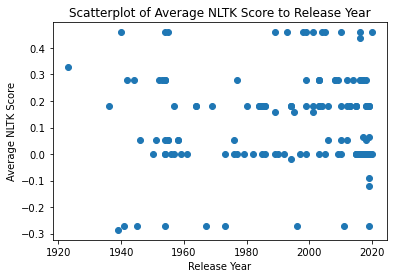

In [63]:
plt.scatter(data['ReleaseYear'], data['Genre_NLTK'])
plt.ylabel('Average NLTK Score')
plt.xlabel('Release Year')
plt.title('Scatterplot of Average NLTK Score to Release Year')
plt.show()

### Revisit Clustering Algorithms, Using NLTK Vader Compound Genre Score + Movie Release Year to Determine the Clusters 

### Cluster Using These Methods:
- K Means
- Expectation Maximization
- Heirarchical

### 1) K-Means

#### How many clusters should we pick? Use Elbow Method 

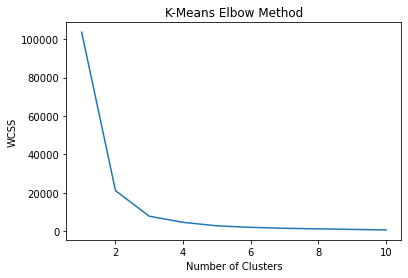

In [101]:
X = data.loc[:, ['ReleaseYear','Genre_NLTK']].values

# Use elbow method to find optimal number of Clusters 

wcss = [] 

# fit KMeans to our data X 
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 43)
    kmeans.fit(X)
    # compute WCSS and append to our list, also called 'Inertia' in KMeans class 
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [102]:
#import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

We want to Maximize Silhouette Score and Minimize Inertia - find place where Inertia is no longer decreasing as fast. 

<Figure size 432x288 with 0 Axes>

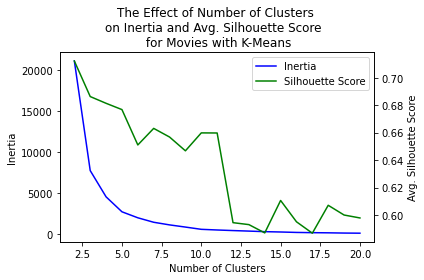

In [103]:
run_kmeans(X, np.arange(2, 21, 1), "Movies")

### K-Means results:
- Elbow method suggests K = 3 clusters
- Silhouette score is still higher for K = 11 clusters

#### K Means with K = 3

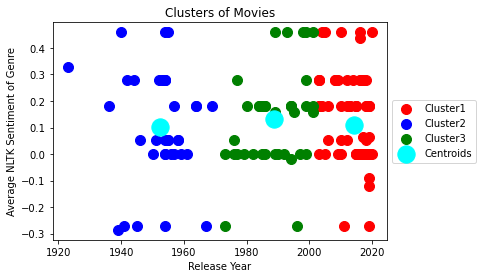

In [104]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)
#print(Y_kmeans)

#print(Y_kmeans.shape)
#print(X.shape)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 11

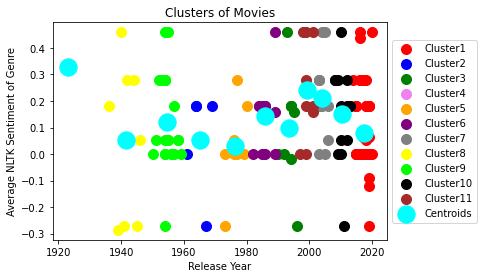

In [109]:
kmeans = KMeans(n_clusters = 11, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_kmeans == 9, 0], X[Y_kmeans == 9, 1], s = 100, color = 'black', label = 'Cluster10')
plt.scatter(X[Y_kmeans == 10, 0], X[Y_kmeans == 10, 1], s = 100, color = 'brown', label = 'Cluster11')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### The above results are not useful because we did not SCALE the data - only the movie Release Year is dividing up our dataset! 

<Figure size 432x288 with 0 Axes>

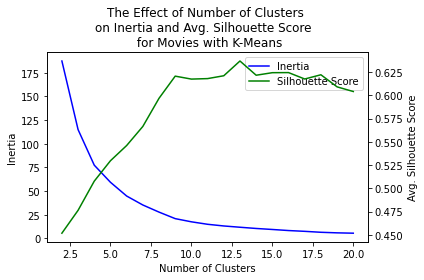

In [118]:
# Use Feature scaling 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

run_kmeans(X_scaled, np.arange(2, 21, 1), "Movies")

- K = 4 looks like a kink in the elbow, otherwise K = 9 

#### K-Means with K = 4, Scaled Data

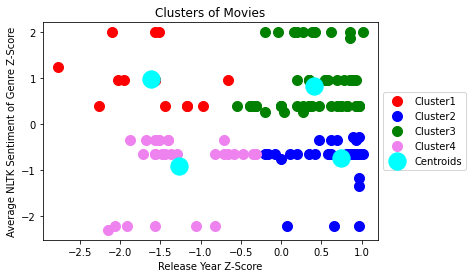

In [119]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 9, Scaled Data

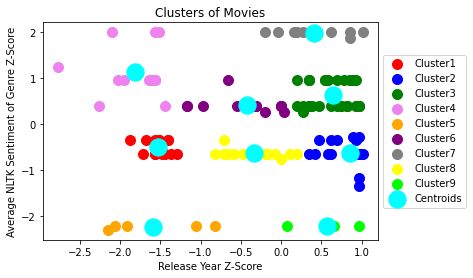

In [120]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)


plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 2) Expectation Maximization

In [124]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()


Covariance type: full


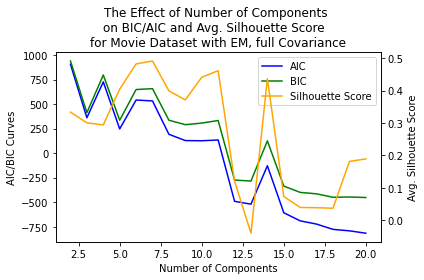

Covariance type: tied


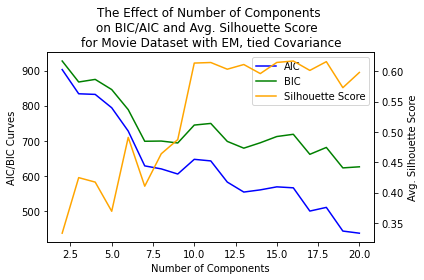

Covariance type: diag


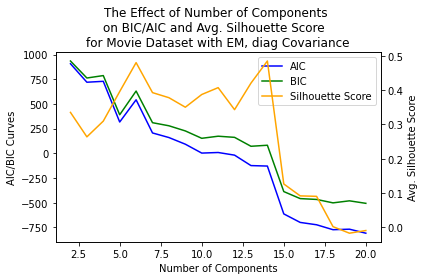

Covariance type: spherical


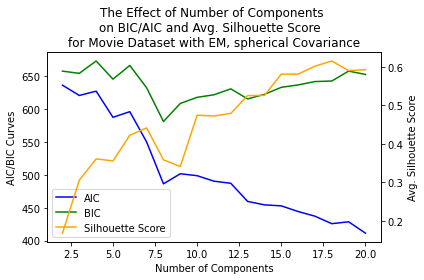

In [125]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X, np.arange(2, 21, 1), "Movie Dataset", cv)

- full: K = 7
- tied: K = 10
- diag: K = 6 
- spherical: K = 7 or 8 


#### Try Tied Covariance with K = 10, this has a high separation of clusters, as determined by the higher Silhouette Score. This shows us how far apart the clusters are. 

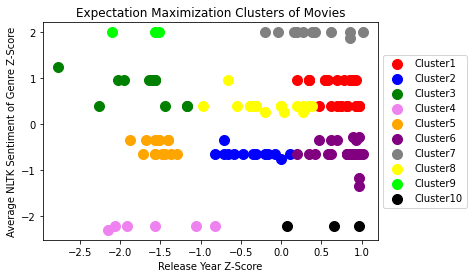

In [148]:
em = EM(n_components = 10, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_em == 9, 0], X[Y_em == 9, 1], s = 100, color = 'black', label = 'Cluster10')

# Add the centroids - Compute for EM, the centroid is point with the maximum density 
#centers = np.empty(shape=(em.n_components, X.shape[1]))
#for i in range(em.n_components):
#    density = scipy.stats.multivariate_normal(cov=em.covariances_[i], mean=em.means_[i]).logpdf(X)
#    centers[i, :] = X[np.argmax(density)]
#plt.scatter(centers[:, 0], centers[:, 1], s=20)

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The cluster 9 looks quite small. It may be better to have fewer clusters 

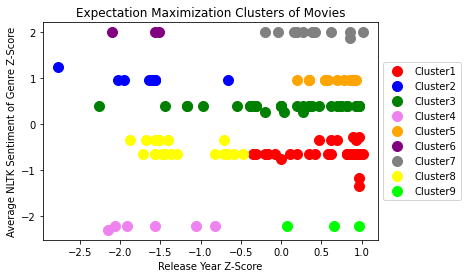

In [149]:
em = EM(n_components = 9, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 3) Hierarchical Clustering 

#### Use Dendrogram to find optimal cluster size - Pick longest Vertical Line. Then, if a horizontal line was drawn through this line, how many cluster groups would we have? 

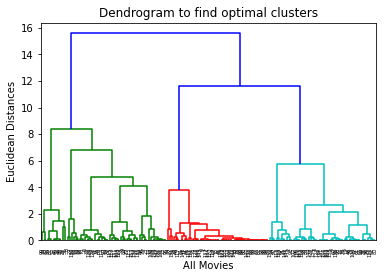

In [143]:
import scipy.cluster.hierarchy as sch

# Ward tries to minimize variance within cluster. Similar to WCSS for KMeans.
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward' ))

plt.title('Dendrogram to find optimal clusters')
plt.xlabel('All Movies')
plt.ylabel('Euclidean Distances')
plt.show()

- Pick line. Looks like 7 Clusters

#### Hierarchical Clustering with K = 7

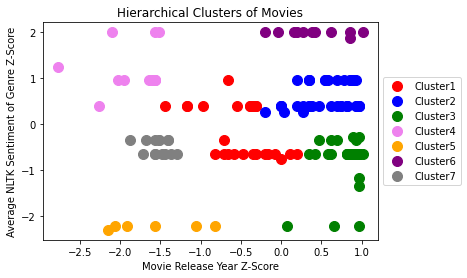

In [147]:
from sklearn.cluster import AgglomerativeClustering 

# Prepare hc algorithm 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
Y_hc = hc.fit_predict(X)

plt.scatter(X[Y_hc == 0, 0], X[Y_hc == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_hc == 1, 0], X[Y_hc == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_hc == 2, 0], X[Y_hc == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_hc == 3, 0], X[Y_hc == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_hc == 4, 0], X[Y_hc == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_hc == 5, 0], X[Y_hc == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_hc == 6, 0], X[Y_hc == 6, 1], s = 100, color = 'gray', label = 'Cluster7')


plt.title('Hierarchical Clusters of Movies')
plt.xlabel('Movie Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()